## import modules

In [7]:
#handling files
import os
import pickle
import numpy as np
import shutil
from tqdm.notebook import tqdm
#from tensorflow.keras.applications.mobilenet import MobileNet,preprocess_input
#from tensorflow.keras.applications.xception import Xception,preprocess_input
#from tensorflow.keras.applications.resnet_rs import ResNetRS101,preprocess_input
#from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add


In [2]:
BASE_DIR='/kaggle/input/flickr8k'
WORKING_DIR='/kaggle/working'

In [3]:
#load vgg16 model
model=VGG16()
# restructure the model
model=Model(inputs=model.inputs,outputs=model.layers[-2].output)
print(model.summary())

553467096/553467096 [==============================] - 18s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [4]:
#extract features from image
features={}
directory=os.path.join(BASE_DIR,'Images')
for img_name in tqdm(os.listdir(directory)):
    #load the image from file
    img_path=directory+'/'+img_name
    image=load_img(img_path,target_size=(224,224))
    #convert image pixels to numpy array
    image=img_to_array(image)
    image=image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    #preporocess image for vgg
    image=preprocess_input(image)
    #extract features
    feature=model.predict(image,verbose=0)
    #get image id
    image_id=img_name.split('.')[0]
    #store_features
    features[image_id]=feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [5]:
# store features in pickle
pickle.dump(features,open(os.path.join(WORKING_DIR,'features.pkl'),'wb'))

In [9]:
shutil.copy("/kaggle/input/features/features.pkl","/kaggle/working/")

'/kaggle/working/features.pkl'

In [32]:
# load features from pickle
with open(os.path.join(WORKING_DIR,'features.pkl'),'rb') as f:
    features=pickle.load(f)

In [33]:
with open(os.path.join(BASE_DIR,'captions.txt'),'r') as f:
    next(f)
    captions_doc=f.read()

In [34]:
# create mapping for image to captions
mapping={}
# process lines
for line in tqdm(captions_doc.split('\n')):
    #split line by comma
    tokens=line.split(',')
    if len(line)<2:
        continue
    image_id,caption=tokens[0],tokens[1:]
    #remove extension from image_id
    image_id=image_id.split('.')[0]
    #convert caption list to string
    caption=' '.join(caption)
    #create list if needed
    if image_id not in mapping:
        mapping[image_id]=[]
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [35]:
len(mapping)

8091

In [36]:
def clean(mapping):
    for key,captions in mapping.items():
        for i in range(len(captions)):
            #take one caption at a time
            caption=captions[i]
            #preprocessing steps 
            #convert to lowert case
            caption=caption.lower()
            # delete digitd and special characters
            caption=caption.replace('[^A-Za-z]','')
            # delete additional spaces
            caption=caption.replace('\s+',' ')
            # add start and end tags to the captions
            caption='<start>' +' '.join([word for word in caption.split() if len(word)>1])+'<end>'
            captions[i]=caption

In [37]:
# before preproces of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [38]:
# preprocess the text
clean(mapping)

In [39]:
# after preprocess
mapping['1000268201_693b08cb0e']

['<start>child in pink dress is climbing up set of stairs in an entry way<end>',
 '<start>girl going into wooden building<end>',
 '<start>little girl climbing into wooden playhouse<end>',
 '<start>little girl climbing the stairs to her playhouse<end>',
 '<start>little girl in pink dress going into wooden cabin<end>']

In [40]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [41]:
len(all_captions)

40455

In [ ]:
all_captions[:10]

In [42]:
#tokenize the text
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1

In [43]:
vocab_size

8483

In [44]:
#get maximum length of the caption
max_length=max(len(caption.split()) for caption in all_captions)
max_length

33

In [45]:
image_ids=list(mapping.keys())
split=int(len(image_ids)*0.90)
train=image_ids[:split]
test=image_ids[split:]
print(len(test))
print(len(train))

810
7281


In [17]:
#create data generator to get data in batches (to avoid session crash)
def data_generator(data_keys,mapping,features,tokenizer,max_length,vocab_size,batch_size):
    #loop over images
    X1,X2,y=list(),list(),list()
    n=0
    while 1:
        for key in data_keys:
            n += 1
            captions=mapping[key]
            #process each caption
            for caption in captions:
                seq=tokenizer.texts_to_sequences([caption])[0]
                #split sequence into X y pairs
                for i in range(1,len(seq)):
                    #split into input and output pairs
                    in_seq,out_seq=seq[:i],seq[i]
                    in_seq=pad_sequences([in_seq],maxlen=max_length)[0]
                    #encode out sequence
                    out_seq=to_categorical([out_seq],num_classes=vocab_size)[0]
                        
                    #store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1,X2,y=np.array(X1),np.array(X2),np.array(y)
                yield [X1,X2],y
                X1,X2,y=list(),list(),list()
                n=0

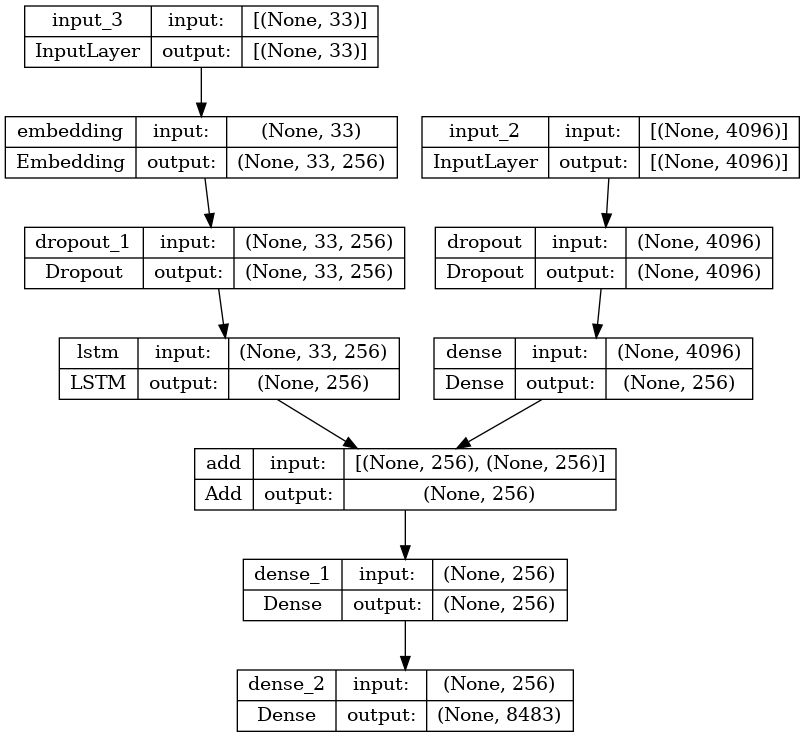

In [18]:
#encoder model
#image feature layers
inputs1=Input(shape=(4096,))
fe1=Dropout(0.4)(inputs1)
fe2=Dense(256,activation='relu')(fe1)
#sequence feature layer
inputs2=Input(shape=(max_length,))
se1=Embedding(vocab_size,256,mask_zero=True)(inputs2)
se2=Dropout(0.4)(se1)
se3=LSTM(256)(se2)
#decoder model
decoder1=add([fe2,se3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

model=Model(inputs=[inputs1,inputs2],outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])


#plot the model
plot_model(model,show_shapes=True)

In [19]:
#train the model
epochs=50
batch_size=64
steps=len(train)//batch_size
vl=[]
l=[]
for i in range(epochs):
    #create data genereator
    generator=data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    #test_generator=data_generator(test, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    #fit for one epoch
    #model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    histr=model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1) 
    #vl.append(histr.history['val_loss'])
    l.append(histr.history['loss'])

113/113 [==============================] - 47s 419ms/step - loss: 1.7716 - accuracy: 0.5205


In [22]:
#save the model
model.save('best_model.h5')


## generate captions for image

In [13]:
def idx_to_word(integer,tokenizer):
    for word,index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [14]:
# generate caption for the image
def predict_caption(model,image,tokenizer,max_length):
    #add start tag for generation purpose
    in_text='<start>'
    #iterate over the max length of the sequence
    for i in range(max_length):
        #encode input sequence
        sequence=tokenizer.texts_to_sequences([in_text])[0]
        #pad the sequence
        sequence=pad_sequences([sequence],max_length)
        #predict next word
        yhat=model.predict([image,sequence],verbose=0)
        #get index with high probability
        yhat=np.argmax(yhat)
        # convert index to word
        word=idx_to_word(yhat,tokenizer)
        #stop if word is not found
        if word is None or word is 'end':
            break
        #append word as input for generating next word
        in_text+=' '+word
        #stop if we reach end tag
        if word=='end':
            break
    return in_text

In [20]:
from tensorflow.keras.models import load_model
model=load_model("/kaggle/working/best_model.h5")

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
#validate with test data
actual,predicted=list(),list()

for key in tqdm(test[0:405]):
    #get actual caption
    captions=mapping[key]
    # predict the caption for image
    y_pred=predict_caption(model,features[key],tokenizer,max_length)
    #split the words
    y_pred=y_pred.split()
    actual_captions=[caption.split() for caption in captions]
    #append words to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
#calculate the BLEU score
print('BLEU-1: %f '% corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))
print('BLEU-2: %f '% corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))

In [48]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('actual image:')
    #for caption in captions:
    print(captions[0])
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('predicted image::')
    print(y_pred)
    plt.imshow(image)
    f = plt.figure()
    f.set_figwidth(5)
    f.set_figheight(5)
    plt.show()

actual image:
<start>man in an orange hat starring at something<end>
predicted image::
<start> man wearing glasses and glasses is wearing blitz hat end


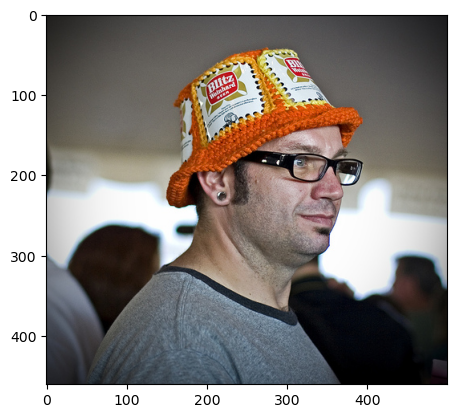

<Figure size 500x500 with 0 Axes>

In [57]:
generate_caption("1007129816_e794419615.jpg")

actual image:
<start>little girl covered in paint sits in front of painted rainbow with her hands in bowl<end>
predicted image::
<start> a girl in field painting rainbow and girl in red dresses sitting on the ground end


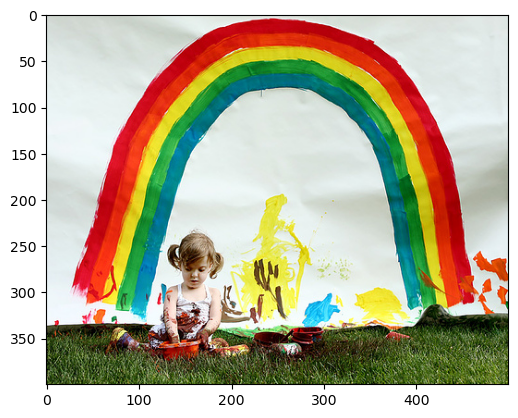

<Figure size 500x500 with 0 Axes>

In [28]:
generate_caption("1002674143_1b742ab4b8.jpg")
